## Package Import

In [11]:
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold


## Data Import and Preprocessing

In [12]:
full_path = 'C:\\Users\\RJEN0307\\Desktop\\Rasmus, Bachelorprojekt\\Data\\1_csv'

patient_numbers = []
patient_data = {}

for file in os.listdir(full_path):
    filename = os.fsdecode(file)
    patient_number = filename.split('_')[0] 
    patient_numbers.append(patient_number)
    patient_file_dir = os.path.join(full_path, filename)
    data = pd.read_csv(patient_file_dir)

    data.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
    data['Event'] = data['Event'].map({'R': 0, 'M': 1, 'F': 2})

    columns_to_remove = [col for col in data.columns if '_N' in col]
    data = data.drop(columns=columns_to_remove)

    resting_data = data[data['Event'] == 0]
    moving_data = data[data['Event'] == 1]
    familiar_data = data[data['Event'] == 2]
    target_count = min(moving_data.shape[0], familiar_data.shape[0])
    resting_data = resting_data.iloc[-target_count:]
    resting_data = resting_data.reset_index(drop=True)
    moving_data = moving_data.reset_index(drop=True)
    familiar_data = familiar_data.reset_index(drop=True)
    balanced_data = pd.concat([resting_data, moving_data, familiar_data]).reset_index(drop=True)

    standarize_list = ['PSD Delta', 'PSD Theta',  'PSD Alpha', 'PSD Beta', 'PSD Gamma', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']
    
    #standarize_list =  ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma']

    scaler = StandardScaler()
    balanced_data[standarize_list] = scaler.fit_transform(balanced_data[standarize_list])
    patient_data[patient_number] = balanced_data
    
    # show patient 10
    print(patient_data['p10'].head())

   Index  Event  PSD Delta  PSD Theta  PSD Alpha  PSD Beta  PSD Gamma  \
0   1500      0  -0.504771  -1.555079  -1.113242 -0.866272  -0.493307   
1   1501      0  -1.207551  -1.285578  -0.421632 -0.046604  -0.189003   
2   1502      0   2.094303  -0.218608  -0.972915 -1.282925  -0.468644   
3   1503      0   1.165314  -0.893731   0.395907 -1.449045  -1.025031   
4   1504      0  -0.710573  -0.297616  -1.010877 -0.883369  -1.267831   

     PSD SE   PSD MSF  PSD Sef90  PSD Sef95        PE      wSMI  Kolmogorov  \
0 -0.208458 -0.717660  -0.079449   0.452049 -0.135324 -0.296510    0.232978   
1  0.559548 -0.149165   0.738750   0.735636 -0.360464 -0.265355    0.580077   
2 -1.750320 -1.018849  -1.755760  -1.873936 -2.154975  0.022672   -0.688630   
3 -1.174411 -1.146854  -0.959331  -0.805472 -0.276526 -0.767685   -0.604848   
4  0.104931 -0.145400  -0.161088   0.230050 -0.436271 -0.012307    0.867331   

   Freq_Slope mean  Freq_Slope std  
0        -0.428410        0.710905  
1         1.

## 1-Dimensional PCA & GMM Unsupervised Classification

C:\Users\RJEN0307\AppData\Local\Temp\ipykernel_12676\330091002.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(adjusted_feature_names, rotation=90)


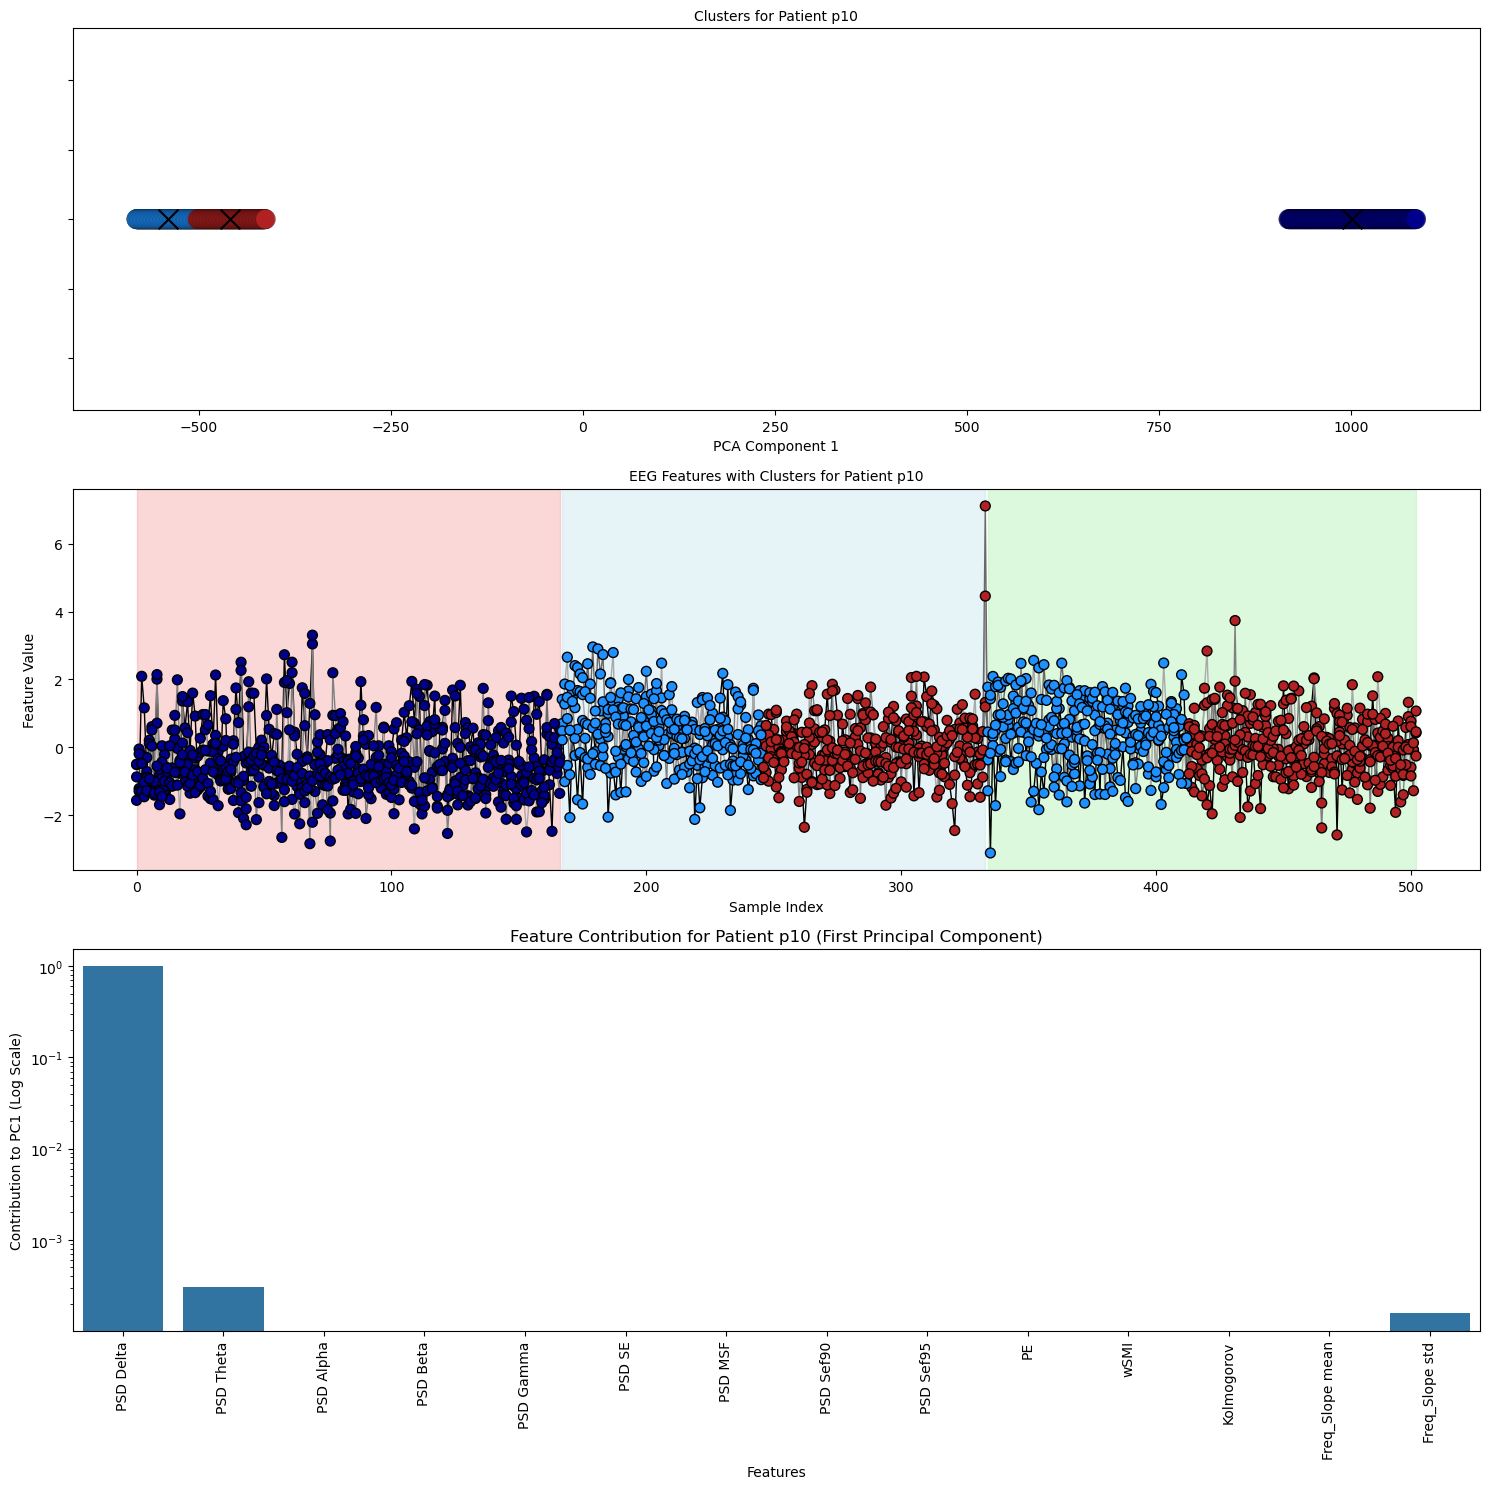

C:\Users\RJEN0307\AppData\Local\Temp\ipykernel_12676\330091002.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(adjusted_feature_names, rotation=90)


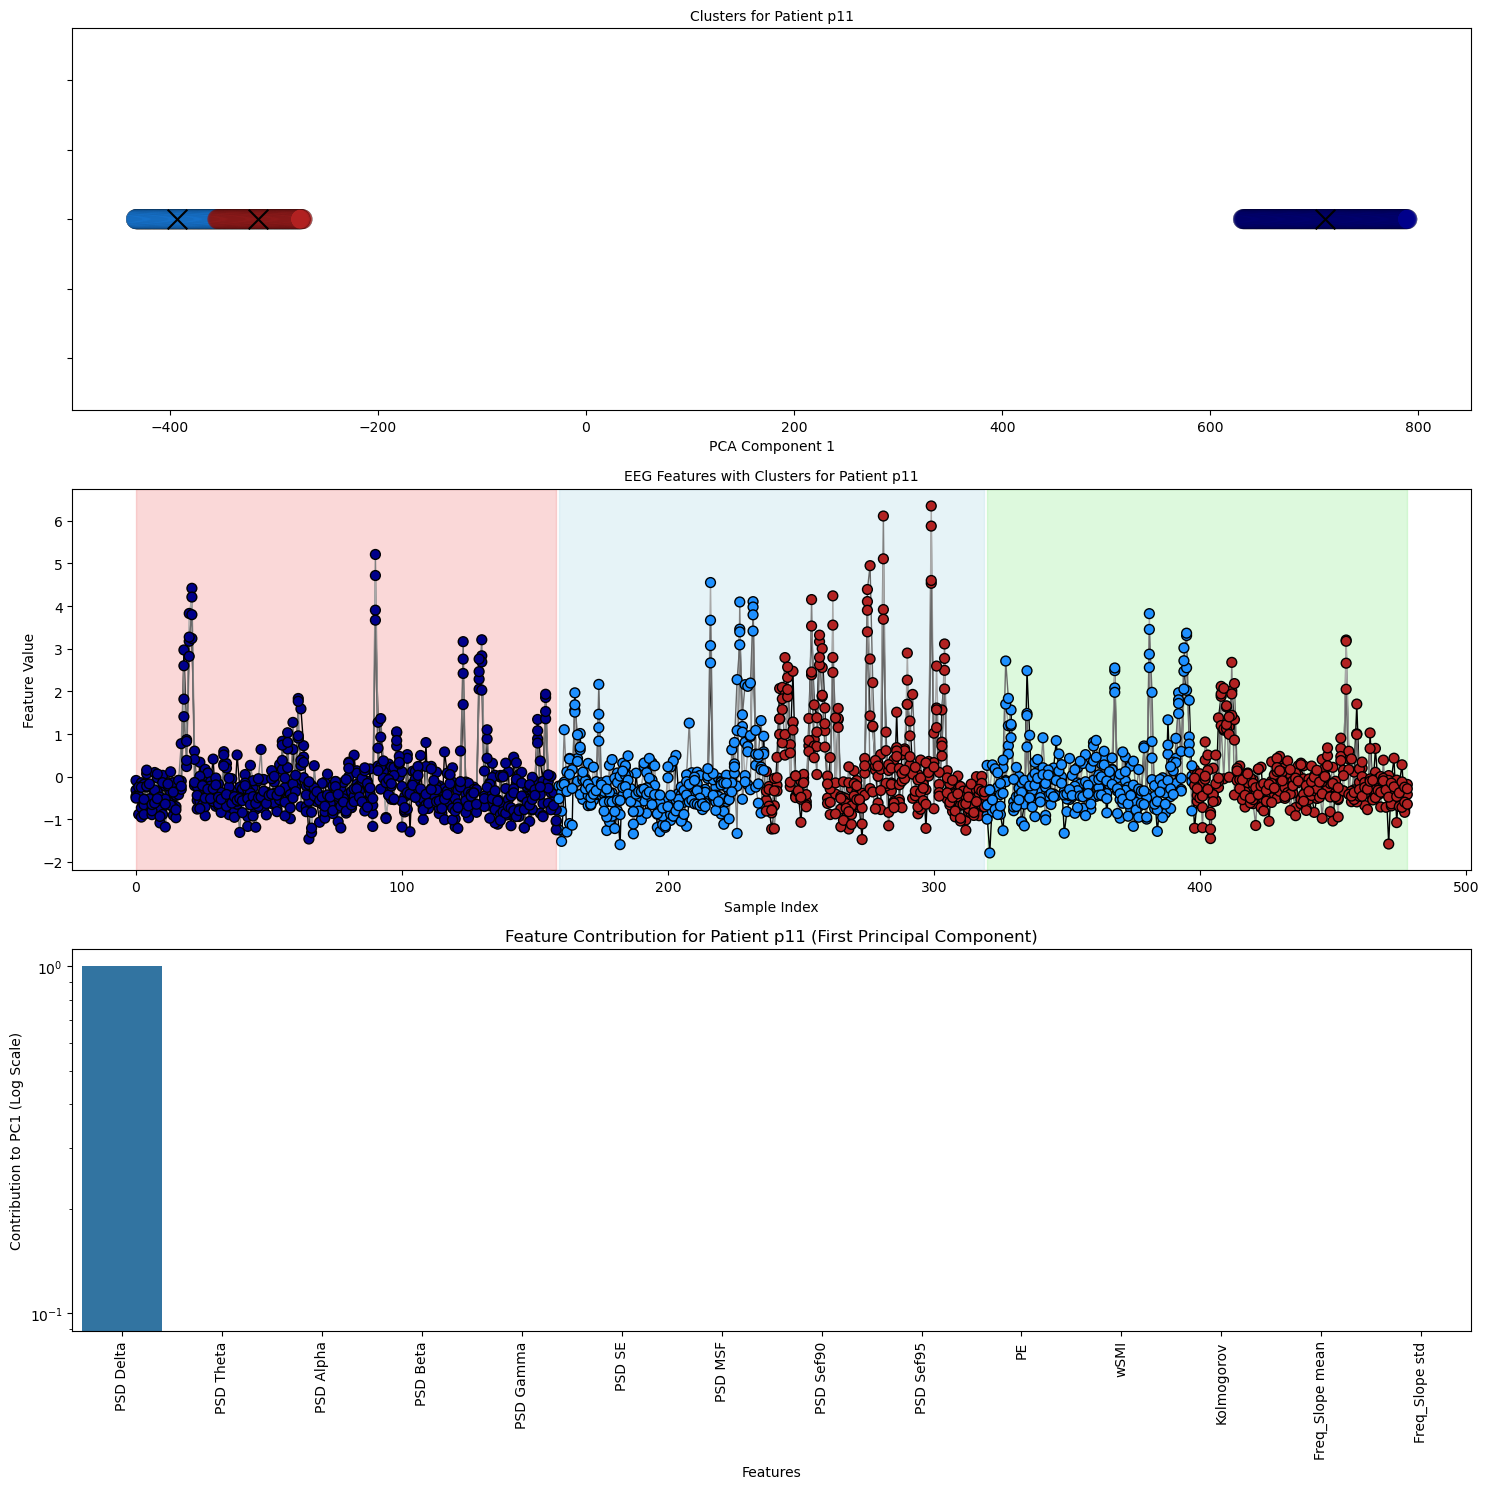

In [13]:
def combined_plot_for_each_patient(patient_data, patients, n_components_pca=5, n_components_gmm=3, save_to_pdf=False, output_pdf_path='combined_patient_plots_final.pdf', contribution_pdf_path='feature_contribution_plot.pdf', output_pca_path='PCAplot_1', pca_plot=False, feature_importance=False):
    feature_names = ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']
    
    if save_to_pdf:
        pdf = PdfPages(output_pdf_path)
    
    feature_importance_count = {feature: 0 for feature in feature_names}
    all_pca_data = []
    all_patient_labels = []

    for patient in patients:
        data = patient_data[patient].copy()
        data_for_pca = data.drop(columns=['Event'])

        # PCA transformation
        pca = PCA(n_components=n_components_pca)
        reduced_data = pca.fit_transform(data_for_pca)
        pca_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components_pca)])
        all_pca_data.append(pca_df)
        all_patient_labels.extend([patient] * len(reduced_data))
        
        # Gaussian Mixture Model clustering
        gmm = GaussianMixture(n_components=n_components_gmm, random_state=0)
        gmm.fit(reduced_data)
        labels = gmm.predict(reduced_data)
        
        # Calculate feature contributions and update feature importance count
        feature_contributions = np.sum(np.abs(pca.components_[:2]), axis=0)
        feature_contributions /= np.sum(feature_contributions)
        importance_threshold = np.percentile(feature_contributions, 75)
        for idx, contribution in enumerate(feature_contributions[:len(feature_names)]):
            if contribution >= importance_threshold:
                feature_importance_count[feature_names[idx]] += 1

        # Plotting for each patient
        fig, axes = plt.subplots(3, 1, figsize=(15, 15))

        # Scatter plot for clusters
        cluster_colors = ['firebrick' if label == 0 else 'darkblue' if label == 1 else 'dodgerblue' for label in labels]
        axes[0].scatter(reduced_data[:, 0], np.zeros_like(reduced_data[:, 0]), 
                        c=cluster_colors, marker='o', edgecolor='black', 
                        linewidth=0.25, s=200, alpha=0.7)
        axes[0].scatter(gmm.means_[:, 0], np.zeros_like(gmm.means_[:, 0]), s=200, c='black', 
                        marker='x', label='Cluster Means')
        axes[0].set_title(f"Clusters for Patient {patient}", fontsize=10)
        axes[0].set_xlabel('PCA Component 1')
        axes[0].set_yticklabels([])

        # Plot EEG features with clusters
        time = np.arange(len(data))
        axes[1].plot(time, data['PSD Delta'], label='Delta (0.5-4 Hz)', color='black', linewidth=1)
        axes[1].plot(time, data['PSD Theta'], label='Theta (4-8 Hz)', color='gray', linewidth=1)
        axes[1].plot(time, data['PSD Beta'], label='Beta (12-30 Hz)', color='darkgray', linewidth=1)
        axes[1].plot(time, data['PSD Gamma'], label='Gamma (>30 Hz)', color='dimgray', linewidth=1)
        
        # Adding scatter points for each feature
        axes[1].scatter(time, data['PSD Delta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Delta)', zorder=3)
        axes[1].scatter(time, data['PSD Theta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Theta)', zorder=3)
        axes[1].scatter(time, data['PSD Beta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Beta)', zorder=3)
        axes[1].scatter(time, data['PSD Gamma'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Gamma)', zorder=3)

        # Event shading
        stimuli_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen'}
        event_groups = data['Event'].ne(data['Event'].shift()).cumsum()
        for _, group_data in data.groupby(event_groups):
            stimulus_value = group_data['Event'].iloc[0]
            if stimulus_value in stimuli_colors:
                start_time = time[group_data.index[0]]
                end_time = time[group_data.index[-1]]
                axes[1].axvspan(start_time, end_time, color=stimuli_colors[stimulus_value], alpha=0.3, zorder=1)
        
        axes[1].set_title(f'EEG Features with Clusters for Patient {patient}', fontsize=10)
        axes[1].set_xlabel('Sample Index')
        axes[1].set_ylabel('Feature Value')

        # Feature contribution bar plot
        pc1_contributions = pca.components_[0]
        min_length = min(len(feature_names), len(pc1_contributions))
        adjusted_feature_names = feature_names[:min_length]
        pc1_contributions = pc1_contributions[:min_length]

        sns.barplot(x=adjusted_feature_names, y=pc1_contributions, ax=axes[2])
        axes[2].set_yscale('log')
        axes[2].set_xticklabels(adjusted_feature_names, rotation=90)
        axes[2].set_xlabel('Features')
        axes[2].set_ylabel('Contribution to PC1 (Log Scale)')
        axes[2].set_title(f'Feature Contribution for Patient {patient} (First Principal Component)')

        plt.tight_layout()

        if save_to_pdf:
            pdf.savefig(fig)
            plt.close(fig)
        else:
            plt.show()

    if save_to_pdf:
        pdf.close()

    # Plot feature importance count across patients if enabled
    if feature_importance:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(feature_importance_count.keys()), y=list(feature_importance_count.values()))
        plt.xlabel('Features')
        plt.ylabel('Count of Importance')
        plt.title('Feature Importance Count Across All Patients')
        plt.xticks(rotation=90)
        plt.tight_layout()
        if save_to_pdf:
            plt.savefig(contribution_pdf_path)
            plt.close()
        else:
            plt.show()

    # Plot combined PCA if enabled
    if pca_plot:
        combined_pca_df = pd.concat(all_pca_data, ignore_index=True)
        combined_pca_df['Patient'] = all_patient_labels
        pair_plot = sns.pairplot(combined_pca_df, hue='Patient', height=1.5, aspect=1, plot_kws={'s': 10}, diag_kind='hist')
        pair_plot._legend.remove()
        plt.suptitle("Combined PCA Pair Plot for All Patients", y=1.02)
        if save_to_pdf:
            pair_plot.savefig(output_pca_path, dpi=300, bbox_inches='tight')
            plt.close()
        else:
            plt.show()

patients = ['p10','p11']

# Example call
combined_plot_for_each_patient(patient_data, patients, n_components_pca=1, n_components_gmm=3, feature_importance=False, pca_plot=False)


## Supervised Learning (From Unsupervised insight)

   Index  Event  PSD Delta  PSD Theta  PSD Alpha  PSD Beta  PSD Gamma  \
0   1500      0  -0.504771  -1.555079  -1.113242 -0.866272  -0.493307   
1   1501      0  -1.207551  -1.285578  -0.421632 -0.046604  -0.189003   
2   1502      0   2.094303  -0.218608  -0.972915 -1.282925  -0.468644   
3   1503      0   1.165314  -0.893731   0.395907 -1.449045  -1.025031   
4   1504      0  -0.710573  -0.297616  -1.010877 -0.883369  -1.267831   

     PSD SE   PSD MSF  PSD Sef90  PSD Sef95        PE      wSMI  Kolmogorov  \
0 -0.208458 -0.717660  -0.079449   0.452049 -0.135324 -0.296510    0.232978   
1  0.559548 -0.149165   0.738750   0.735636 -0.360464 -0.265355    0.580077   
2 -1.750320 -1.018849  -1.755760  -1.873936 -2.154975  0.022672   -0.688630   
3 -1.174411 -1.146854  -0.959331  -0.805472 -0.276526 -0.767685   -0.604848   
4  0.104931 -0.145400  -0.161088   0.230050 -0.436271 -0.012307    0.867331   

   Freq_Slope mean  Freq_Slope std  
0        -0.428410        0.710905  
1         1.

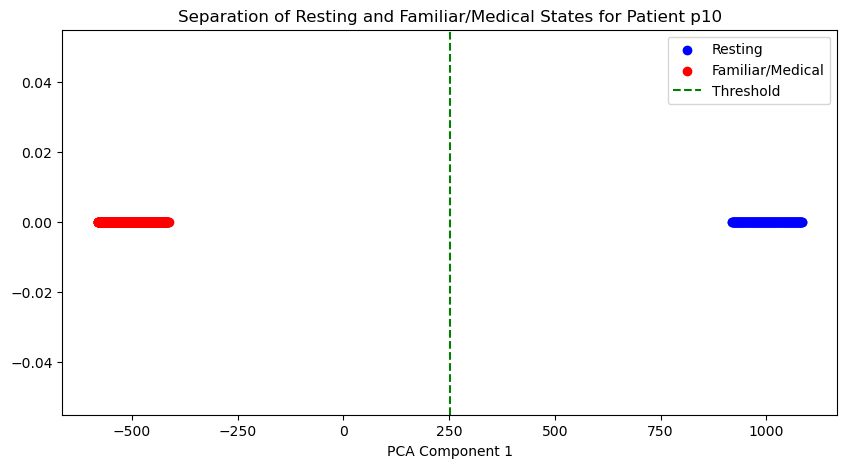

In [23]:
def classification_with_cross_validation(patient_data, patients, n_components_pca=1, n_splits=2, save_to_pdf=False, output_pdf_path='combined_patient_plots_final.pdf'):
    feature_names = ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']
    
    if save_to_pdf:
        pdf = PdfPages(output_pdf_path)
    
    for patient in patients:
        data = patient_data[patient].copy()
        print(data.head())

        # Define the events as resting or combined familiar/medical
        labels = data['Event'].apply(lambda x: 1 if x in [1, 2] else 0).values  # Familiar/Medical as 1, Resting as 0
        data_for_pca = data.drop(columns=['Event']).values

        # Cross-validation setup
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_accuracies = []

        for train_index, test_index in kf.split(data_for_pca):
            X_train, X_test = data_for_pca[train_index], data_for_pca[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
            
            # Apply PCA on the training data and transform both train and test sets
            pca = PCA(n_components=n_components_pca)
            X_train_pca = pca.fit_transform(X_train)
            X_test_pca = pca.transform(X_test)

            # Determine the threshold based on training data
            threshold = (X_train_pca[y_train == 0].mean() + X_train_pca[y_train == 1].mean()) / 2

            # Predict using the threshold
            y_pred = (X_test_pca[:, 0] < threshold).astype(int)

            # Evaluate accuracy for this fold
            fold_accuracy = accuracy_score(y_test, y_pred)
            fold_accuracies.append(fold_accuracy)

            # Optionally, print confusion matrix and classification report for each fold
            #print(f"Fold Confusion Matrix for Patient {patient}:")
            #print(confusion_matrix(y_test, y_pred))
            #print("Fold Classification Report:")
            #print(classification_report(y_test, y_pred))
            #print(pca.components_[0])

            #shape of x_train, x_test, y_train, y_test
            print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
            X_train.shape

        # Calculate and print the average accuracy across all folds
        average_accuracy = np.mean(fold_accuracies)
        #print(f"Average Cross-Validation Accuracy for Patient {patient}: {average_accuracy}")

        # Plot PCA component 1 with threshold
        fig, ax = plt.subplots(figsize=(10, 5))
        X_pca_full = pca.fit_transform(data_for_pca)
        threshold = (X_pca_full[labels == 0].mean() + X_pca_full[labels == 1].mean()) / 2
        ax.scatter(X_pca_full[labels == 0, 0], np.zeros_like(X_pca_full[labels == 0, 0]), color='blue', label='Resting')
        ax.scatter(X_pca_full[labels == 1, 0], np.zeros_like(X_pca_full[labels == 1, 0]), color='red', label='Familiar/Medical')
        ax.axvline(x=threshold, color='green', linestyle='--', label='Threshold')
        ax.set_title(f"Separation of Resting and Familiar/Medical States for Patient {patient}")
        ax.set_xlabel('PCA Component 1')
        ax.legend()

        if save_to_pdf:
            pdf.savefig(fig)
            plt.close(fig)
        else:
            plt.show()

    if save_to_pdf:
        pdf.close()

# Example usage for all patients
patients = ['p10']
classification_with_cross_validation(patient_data, patients, n_components_pca=1, n_splits=2)
